<a href="https://colab.research.google.com/github/anikak24/Baltimore-Ravens-x-Strength-in-Numbers-Analytics-Project/blob/main/Ravens_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baltimore Ravens Project: Logistic Regression Model Based on Game Situation, Throw Context, Environment

In [2]:
!pip install nflreadpy pandas numpy scikit-learn lightgbm pyarrow

In [3]:
import nflreadpy as nfl
import pandas as pd
import numpy as np

seasons = [2021, 2022, 2023, 2024]
pbp = nfl.load_pbp(seasons)  # returns pandas DataFrame directly

print(pbp.shape)
pbp.head()


(198513, 372)


play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,…,home_coach,away_coach,stadium_id,game_stadium,aborted_play,success,passer,passer_jersey_number,rusher,rusher_jersey_number,receiver,receiver_jersey_number,pass,rush,first_down,special,play,passer_id,rusher_id,receiver_id,name,jersey_number,id,fantasy_player_name,fantasy_player_id,fantasy,fantasy_id,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
f64,str,str,str,str,str,i32,str,str,str,str,f64,str,f64,f64,f64,str,f64,f64,f64,f64,f64,i32,str,str,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,str,…,str,str,str,str,f64,f64,str,i32,str,i32,str,i32,f64,f64,f64,f64,f64,str,str,str,str,i32,str,str,str,str,str,f64,f64,f64,f64,f64,i32,f64,f64,f64,f64
1.0,"""2021_01_ARI_TEN""","""2021091207""","""TEN""","""ARI""","""REG""",1,null,null,null,null,null,"""2021-09-12""",900.0,1800.0,3600.0,"""Half1""",0.0,null,0.0,1.0,null,0,"""15:00""","""ARI 35""",0.0,null,"""GAME""",null,null,0.0,0.0,null,0.0,0.0,0.0,null,…,"""Mike Vrabel""","""Kliff Kingsbury""","""NAS00""","""Nissan Stadium""",0.0,0.0,null,null,null,null,null,null,0.0,0.0,null,0.0,0.0,null,null,null,null,null,null,null,null,null,null,0.0,1.0,0.0,null,null,null,null,null,null,null
40.0,"""2021_01_ARI_TEN""","""2021091207""","""TEN""","""ARI""","""REG""",1,"""TEN""","""home""","""ARI""","""ARI""",35.0,"""2021-09-12""",900.0,1800.0,3600.0,"""Half1""",0.0,1.0,0.0,1.0,null,0,"""15:00""","""ARI 35""",0.0,0.0,"""5-M.Prater kicks 65 yards from…","""kickoff""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,…,"""Mike Vrabel""","""Kliff Kingsbury""","""NAS00""","""Nissan Stadium""",0.0,0.0,null,null,null,null,null,null,0.0,0.0,0.0,1.0,0.0,null,null,null,null,null,null,null,null,null,null,0.0,1.0,0.0,null,null,null,null,null,null,null
55.0,"""2021_01_ARI_TEN""","""2021091207""","""TEN""","""ARI""","""REG""",1,"""TEN""","""home""","""ARI""","""TEN""",75.0,"""2021-09-12""",900.0,1800.0,3600.0,"""Half1""",0.0,1.0,0.0,1.0,1.0,0,"""15:00""","""TEN 25""",10.0,0.0,"""(15:00) 22-D.Henry left tackle…","""run""",-3.0,0.0,0.0,0.0,0.0,0.0,0.0,null,…,"""Mike Vrabel""","""Kliff Kingsbury""","""NAS00""","""Nissan Stadium""",0.0,0.0,null,null,"""D.Henry""",22,null,null,0.0,1.0,0.0,0.0,1.0,null,"""00-0032764""",null,"""D.Henry""",22,"""00-0032764""","""D.Henry""","""00-0032764""","""D.Henry""","""00-0032764""",0.0,1.0,-1.399805,null,null,null,null,null,0.491433,-49.143299
76.0,"""2021_01_ARI_TEN""","""2021091207""","""TEN""","""ARI""","""REG""",1,"""TEN""","""home""","""ARI""","""TEN""",78.0,"""2021-09-12""",863.0,1763.0,3563.0,"""Half1""",0.0,1.0,0.0,1.0,2.0,0,"""14:23""","""TEN 22""",13.0,0.0,"""(14:23) (Shotgun) 17-R.Tannehi…","""pass""",3.0,1.0,0.0,1.0,0.0,0.0,0.0,"""short""",…,"""Mike Vrabel""","""Kliff Kingsbury""","""NAS00""","""Nissan Stadium""",0.0,1.0,"""R.Tannehill""",17,null,null,"""D.Henry""",22,1.0,0.0,0.0,0.0,1.0,"""00-0029701""",null,"""00-0032764""","""R.Tannehill""",17,"""00-0029701""","""D.Henry""","""00-0032764""","""D.Henry""","""00-0032764""",0.0,1.0,0.032412,1.165133,5.803177,4,0.896654,0.125098,0.697346,30.265415
100.0,"""2021_01_ARI_TEN""","""2021091207""","""TEN""","""ARI""","""REG""",1,"""TEN""","""home""","""ARI""","""TEN""",75.0,"""2021-09-12""",822.0,1722.0,3522.0,"""Half1""",0.0,1.0,0.0,1.0,3.0,0,"""13:42""","""TEN 25""",10.0,0.0,"""(13:42) (Shotgun) 17-R.Tannehi…","""pass""",0.0,1.0,0.0,1.0,0.0,0.0,0.0,"""short""",…,"""Mike Vrabel""","""Kliff Kingsbury""","""NAS00""","""Nissan Stadium""",0.0,0.0,"""R.Tannehill""",17,null,null,"""C.Rogers""",80,1.0,0.0,0.0,0.0,1.0,"""00-0029701""",null,"""00-0032355""","""R.Tannehill""",17,"""00-0029701""","""C.Rogers"

In [4]:
# was having trouble with polars and pandas - wanted everything as pandas df
import polars as pl

if isinstance(pbp, pl.DataFrame):
    pbp = pbp.to_pandas(use_pyarrow_extension_array=True)
    print("Converted Polars → pandas DataFrame!")

print("pbp type:", type(pbp))

Converted Polars → pandas DataFrame!
pbp type: <class 'pandas.core.frame.DataFrame'>


In [5]:
list(pbp.columns)


['play_id',
 'game_id',
 'old_game_id',
 'home_team',
 'away_team',
 'season_type',
 'week',
 'posteam',
 'posteam_type',
 'defteam',
 'side_of_field',
 'yardline_100',
 'game_date',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'game_half',
 'quarter_end',
 'drive',
 'sp',
 'qtr',
 'down',
 'goal_to_go',
 'time',
 'yrdln',
 'ydstogo',
 'ydsnet',
 'desc',
 'play_type',
 'yards_gained',
 'shotgun',
 'no_huddle',
 'qb_dropback',
 'qb_kneel',
 'qb_spike',
 'qb_scramble',
 'pass_length',
 'pass_location',
 'air_yards',
 'yards_after_catch',
 'run_location',
 'run_gap',
 'field_goal_result',
 'kick_distance',
 'extra_point_result',
 'two_point_conv_result',
 'home_timeouts_remaining',
 'away_timeouts_remaining',
 'timeout',
 'timeout_team',
 'td_team',
 'td_player_name',
 'td_player_id',
 'posteam_timeouts_remaining',
 'defteam_timeouts_remaining',
 'total_home_score',
 'total_away_score',
 'posteam_score',
 'defteam_score',
 'score_differential',
 'po

In [6]:
df = pbp.copy()

# have only pass attempts
df = pbp[(pbp["pass"] == 1) & (pbp["pass_attempt"] == 1)].copy()

# removes non-real plays
for col in ["spike", "qb_spike", "qb_kneel", "throwaway", "no_play"]:
    if col in df.columns:
        df = df[df[col].fillna(False) == False].copy()

# requires air_yards - ensure valid passes
if "air_yards" in df.columns:
    df = df[df["air_yards"].notna()]

# remove duplicate plays by game_id + play_id
if {"game_id","play_id"}.issubset(df.columns):
    before = len(df)
    df = df.drop_duplicates(subset=["game_id","play_id"]).copy()
    print(f"Removed duplicate plays: {before - len(df)}")

for b in ["shotgun","no_huddle"]:
    if b in df.columns:
        df[b] = df[b].fillna(False).astype(int)

wanted_col = [
    "season","week","game_id","play_id",
    "posteam","defteam","passer","passer_id",
    "complete_pass","air_yards","down","ydstogo","yardline_100",
    "pass_length","pass_location",
    "half_seconds_remaining","game_seconds_remaining",
    "score_differential","qtr",
    "shotgun","no_huddle","roof","surface","temp","wind",
    "cp","cpoe"
]
df = df[[c for c in wanted_col if c in df.columns]].copy()

# valid qbs with 600+ attempts
id_col = "passer_id" if "passer_id" in df.columns else "passer"
attempt_counts = (
    df.groupby(id_col, dropna=False)
      .size()
      .rename("attempts")
      .reset_index()
)
qualified_ids = set(attempt_counts.loc[attempt_counts["attempts"] >= 600, id_col])
before = len(df)
df = df[df[id_col].isin(qualified_ids)].copy()
after = len(df)

print(f"Qualified passers (≥600 attempts): {len(qualified_ids)}")
print(f"Rows kept: {after} / {before}")
print("Columns:", list(df.columns))

# show top 10 passer attempt counts
display(
    df.groupby(["passer"] if "passer" in df.columns else [id_col])
      .size()
      .rename("attempts")
      .reset_index()
      .sort_values("attempts", ascending=False)
      .head(10)
)

pbp.head(50)

Removed duplicate plays: 0
Qualified passers (≥600 attempts): 42
Rows kept: 61429 / 76212
Columns: ['season', 'week', 'game_id', 'play_id', 'posteam', 'defteam', 'passer', 'passer_id', 'complete_pass', 'air_yards', 'down', 'ydstogo', 'yardline_100', 'pass_length', 'pass_location', 'half_seconds_remaining', 'game_seconds_remaining', 'score_differential', 'qtr', 'shotgun', 'no_huddle', 'roof', 'surface', 'temp', 'wind', 'cp', 'cpoe']


,passer,attempts
32,P.Mahomes,2934
14,J.Allen,2565
21,J.Herbert,2400
16,J.Burrow,2386
20,J.Goff,2360
31,M.Stafford,2184
39,T.Lawrence,2113
22,J.Hurts,2044
11,D.Prescott,2036
8,D.Carr,2005


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
0,1.0,2021_01_ARI_TEN,2021091207,TEN,ARI,REG,1,<NA>,<NA>,<NA>,...,0.0,1.0,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,40.0,2021_01_ARI_TEN,2021091207,TEN,ARI,REG,1,TEN,home,ARI,...,0.0,1.0,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,55.0,2021_01_ARI_TEN,2021091207,TEN,ARI,REG,1,TEN,home,ARI,...,0.0,1.0,-1.399805,<NA>,<NA>,<NA>,<NA>,<NA>,0.491433,-49.143299
3,76.0,2021_01_ARI_TEN,2021091207,TEN,ARI,REG,1,TEN,home,ARI,...,0.0,1.0,0.032412,1.165133,5.803177,4,0.896654,0.125098,0.697346,30.265415
4,100.0,2021_01_ARI_TEN,2021091207,TEN,ARI,REG,1,TEN,home,ARI,...,0.0,1.0,-1.532898,0.256036,4.147637,2,0.965009,0.965009,0.978253,2.174652
5,122.0,2021_01_ARI_TEN,2021091207,TEN,ARI,REG,1,TEN,home,ARI,...,1.0,1.0,-0.345293,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
6,152.0,2021_01_ARI_TEN,2021091207,TEN,ARI,REG,1,ARI,away,TEN,...,1.0,1.0,2.69289,0.567838,7.420427,4,1.0,1.0,0.458989,54.10113
7,181.0,2021_01_ARI_TEN,2021091207,TEN,ARI,REG,1,ARI,away,TEN,...,1.0,1.0,-1.009908,<NA>,<NA>,<NA>,<NA>,<NA>,0.419833,-41.983327
8,218.0,2021_01_ARI_TEN,2021091207,TEN,ARI,REG,1,ARI,away,TEN,...,1.0,1.0,-0.51109,1.036891,10.339405,9,0.478471,0.079696,0.684949,31.505138
9,253.0,2021_01_ARI_TEN,2021091207,TEN,ARI,REG,1,ARI,away,TEN,...,1.0,1.0,2.182015,0.517965,3.045047,1,1.0,0.998799,0.775463,22.453719


In [7]:
top_qbs = (
    df.groupby(["passer"] if "passer" in df.columns else [id_col])
      .size()
      .rename("attempts")
      .reset_index()
      .sort_values("attempts", ascending=False)
      .head(15)
)

print("Top 15 Passers by Number of Attempts (≥600):")
print(top_qbs.to_string(index=False))

Top 15 Passers by Number of Attempts (≥600):
      passer  attempts
   P.Mahomes      2934
     J.Allen      2565
   J.Herbert      2400
    J.Burrow      2386
      J.Goff      2360
  M.Stafford      2184
  T.Lawrence      2113
     J.Hurts      2044
  D.Prescott      2036
      D.Carr      2005
   K.Cousins      1993
  B.Mayfield      1980
T.Tagovailoa      1780
     G.Smith      1770
   L.Jackson      1732


In [8]:
# Sanity Checks
print("Rows in df:", len(df))
print("Seasons:", sorted(df["season"].dropna().unique()))
print("Unique passers:", df["passer"].nunique() if "passer" in df.columns else "n/a")

# Completion % by down
comp_by_down = (df.groupby("down")["complete_pass"].mean().rename("completion_rate").reset_index())
display(comp_by_down.style.format({"completion_rate": "{:.1%}"}))

# Completion % by yards-to-go bins
bins_yds = [0,3,6,10,15,20,30,50,1e9]
labels_yds = ["0-3","4-6","7-10","11-15","16-20","21-30","31-50","50+"]
df["ydstogo_bin"] = pd.cut(pd.to_numeric(df["ydstogo"], errors="coerce"), bins=bins_yds, labels=labels_yds, right=True)
comp_by_yds = df.groupby("ydstogo_bin")["complete_pass"].mean().rename("completion_rate").reset_index()
display(comp_by_yds.style.format({"completion_rate": "{:.1%}"}))

# Completion % by air-yards buckets
bins_air = [-10,0,5,10,15,20,30,50,80]
labels_air = ["-10–0","1–5","6–10","11–15","16–20","21–30","31–50","50+"]
df["air_yards_bin"] = pd.cut(pd.to_numeric(df["air_yards"], errors="coerce"), bins=bins_air, labels=labels_air, right=True)
comp_by_air = df.groupby("air_yards_bin")["complete_pass"].mean().rename("completion_rate").reset_index()
display(comp_by_air.style.format({"completion_rate": "{:.1%}"}))

Rows in df: 61429
Seasons: [2021, 2022, 2023, 2024]
Unique passers: 42


,down,completion_rate
0,1.000000,68.0%
1,2.000000,67.5%
2,3.000000,60.7%
3,4.000000,54.0%


/tmp/ipython-input-247727292.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_by_yds = df.groupby("ydstogo_bin")["complete_pass"].mean().rename("completion_rate").reset_index()


,ydstogo_bin,completion_rate
0,0-3,63.1%
1,4-6,62.5%
2,7-10,66.5%
3,11-15,64.8%
4,16-20,70.2%
5,21-30,73.5%
6,31-50,77.8%
7,50+,


/tmp/ipython-input-247727292.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_by_air = df.groupby("air_yards_bin")["complete_pass"].mean().rename("completion_rate").reset_index()


,air_yards_bin,completion_rate
0,-10–0,77.9%
1,1–5,74.5%
2,6–10,63.7%
3,11–15,56.9%
4,16–20,52.8%
5,21–30,39.2%
6,31–50,31.5%
7,50+,23.5%


In [9]:
# Defensive context
# Account for how the defense has been performing over the weeks - factors how well the QB plays

def add_defense_rolling_comp(df_in: pd.DataFrame, window: int = 4) -> pd.DataFrame:
    req = {"season", "week", "defteam", "complete_pass"}
    output = df_in.copy()

    if not req.issubset(output.columns):
        output["opp_comp_pct_roll"] = np.nan
        return output

    temp = output[["season", "week", "defteam", "complete_pass"]].copy()
    temp["is_comp"] = temp["complete_pass"].astype(int)

    wk = (
        temp.groupby(["season", "defteam", "week"], as_index=False)
           .agg(opp_comp=("is_comp", "mean"))
           .sort_values(["defteam", "season", "week"])
           .reset_index(drop=True)
    )

    # Compute rolling mean on the shifted series within each (defteam, season)
    grp = wk.groupby(["defteam", "season"])["opp_comp"]
    rolled = grp.apply(lambda s: s.shift().rolling(window, min_periods=1).mean())

    # Assign by position (values) to avoid index reindexing issues
    wk["opp_comp_pct_roll"] = rolled.to_numpy()

    # Merge back to all plays
    output = output.merge(
        wk[["season", "defteam", "week", "opp_comp_pct_roll"]],
        on=["season", "defteam", "week"],
        how="left",
    )
    return output

In [10]:
import pandas as pd
import numpy as np

# define  feature sets
num_features = [c for c in [
    "air_yards","down","ydstogo","yardline_100",
    "half_seconds_remaining","game_seconds_remaining",
    "score_differential","qtr","shotgun","no_huddle","temp","wind",
    "opp_comp_pct_roll"
] if c in df.columns]

cat_features = [c for c in ["pass_length","pass_location","roof","surface"] if c in df.columns]

# 1) Coerce numerics and drop rows missing any required numeric
df_numfix = df.copy()
for c in num_features:
    df_numfix[c] = pd.to_numeric(df_numfix[c], errors="coerce")

# need to have numeric stats for modeling
req_numeric = ["air_yards","down","ydstogo"]
req_numeric = [c for c in req_numeric if c in df_numfix.columns]
mask_ok = df_numfix[req_numeric].notna().all(axis=1)
df_numfix = df_numfix.loc[mask_ok].copy()

# standardize categoricals
for c in cat_features:
    df_numfix[c] = df_numfix[c].astype("string").fillna("Unknown")

# training model
seasons_train = [2021, 2022, 2023]
seasons_valid = [2024]

train = df_numfix[df_numfix["season"].isin(seasons_train)].copy()
valid = df_numfix[df_numfix["season"].isin(seasons_valid)].copy()

target_col = "complete_pass"

X_train = train[num_features + cat_features].copy()
y_train = train[target_col].astype(int)

X_valid = valid[num_features + cat_features].copy()
y_valid = valid[target_col].astype(int)

print("Shapes → X_train:", X_train.shape, " X_valid:", X_valid.shape)

Shapes → X_train: (48000, 16)  X_valid: (13429, 16)


In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score

# Preprocess data
num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
])
cat_pipe = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preproc = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_features),
        ("cat", cat_pipe, cat_features),
    ],
    remainder="drop"
)

# Logistic Regression Model
model = LogisticRegression(max_iter=800, solver="lbfgs", random_state=42)
complete_model = Pipeline([("prep", preproc), ("clf", model)])

# Fit on 2021–2023
complete_model.fit(X_train, y_train)

# Calibrate on 2024 (better reflected probabilities)
logit_cal = CalibratedClassifierCV(complete_model, cv="prefit", method="sigmoid").fit(X_valid, y_valid)

# Play-level expected completion on 2024
valid = valid.copy()
valid["complete_model"] = logit_cal.predict_proba(X_valid)[:, 1]

# Quick metrics
print("Brier:", brier_score_loss(y_valid, valid["complete_model"]),
      "LogLoss:", log_loss(y_valid, valid["complete_model"]),
      "AUC:", roc_auc_score(y_valid, valid["complete_model"]))

print(complete_model.named_steps["clf"].n_iter_)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Brier: 0.20263908187256685 LogLoss: 0.5942052541468363 AUC: 0.6735688884647765
[800]


In [34]:
#Calculating weight (coefficients) + importance of features

import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.base import clone

def get_ohe_cols(pipeline, cat_features):
    preproc = pipeline.named_steps["prep"]
    have_cat = ("cat" in preproc.named_transformers_) and (len(cat_features) > 0)
    if not have_cat:
        return []
    ohe = preproc.named_transformers_["cat"].named_steps["ohe"]
    return list(ohe.get_feature_names_out(cat_features))

def get_num_cols(num_features):
    return list(num_features)

In [38]:
preproc = complete_model.named_steps["prep"]
clf = complete_model.named_steps["clf"]

num_cols = get_num_cols(num_features)
ohe_cols = get_ohe_cols(complete_model, cat_features)
transformed_cols = num_cols + ohe_cols

# the learned weights (slopes) and the baseline log-odds.
coefs = clf.coef_.ravel()
intercept = float(clf.intercept_)

# assemble the table
coeffs = pd.DataFrame({
    "feature_transformed": transformed_cols,
    "weight": coefs
})
coeffs["abs_weight"]  = coeffs["weight"].abs()
coeffs["importance"]  = coeffs["abs_weight"] / coeffs["abs_weight"].sum()
coeffs["odds_ratio"]  = np.exp(coeffs["weight"])

def orig_name(col):
    if col in num_cols:
        return col
    # split just once so "pass_length_short" -> "pass_length"
    return col.split("_", 1)[0]

# map back to original feature names
coeffs["feature_original"] = coeffs["feature_transformed"].map(orig_name)
coeffs["feature_original"] = coeffs["feature_transformed"].apply(
    lambda x: "pass_length" if "pass_length" in x else
              "pass_location" if "pass_location" in x else
              "roof" if "roof" in x else
              "surface" if "surface" in x else x
)

/tmp/ipython-input-322162797.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercept = float(clf.intercept_)


In [37]:
# aggregate importance by original feature
agg_importance = (
    coeffs.groupby("feature_original")["abs_weight"].sum()
    .pipe(lambda x: (x / x.sum()).rename("importance_aggregated"))
    .reset_index()
    .sort_values("importance_aggregated", ascending=False)
)

print(f"Intercept (baseline log-odds): {intercept:.4f}")
print("\nTop transformed features by |coef| (normalized importance):")
display(coeffs.sort_values("importance", ascending=False).head(20))

print("\nAggregated importance by original feature:")
display(agg_importance.head(20))


Intercept (baseline log-odds): 0.0315

Top transformed features by |coef| (normalized importance):


,feature_transformed,weight,abs_weight,importance,odds_ratio,feature_original
7,qtr,0.142957,0.142957,0.148944,1.153680,qtr
17,pass_location_middle,0.131143,0.131143,0.136635,1.140131,pass_location
1,down,-0.098148,0.098148,0.102258,0.906515,down
18,pass_location_right,-0.090129,0.090129,0.093904,0.913813,pass_location
9,no_huddle,0.059354,0.059354,0.061839,1.061151,no_huddle
0,air_yards,-0.056205,0.056205,0.058559,0.945345,air_yards
22,roof_outdoors,-0.047763,0.047763,0.049763,0.953359,roof
8,shotgun,-0.046115,0.046115,0.048046,0.954932,shotgun
14,pass_length_short,0.038673,0.038673,0.040292,1.039430,pass_length
20,roof_dome,0.033916,0.033916,0.035336,1.034497,roof



Aggregated importance by original feature:


,feature_original,importance_aggregated
6,pass_location,0.240450
7,qtr,0.148944
8,roof,0.132347
11,surface,0.126149
1,down,0.102258
4,no_huddle,0.061839
0,air_yards,0.058559
10,shotgun,0.048046
5,pass_length,0.047764
15,ydstogo,0.013242


In [12]:
# Your play-level CPOE (Actual - Expected by your model)
valid["your_cpoe"] = valid["complete_pass"].astype(int) - valid["complete_model"]

# nflfastR comparison (play-level)
has_cp = "cp" in valid.columns
has_cpoe = "cpoe" in valid.columns

if has_cp:
    # correlation between your expected prob and nflfastR expected prob
    corr_cp = np.corrcoef(valid["complete_model"], valid["cp"])[0,1]
    print(f"Correlation (your complete_model vs nflfastR cp): {corr_cp:.3f}")

if has_cpoe:
    # correlation between your CPOE and nflfastR CPOE
    corr_cpoe = np.corrcoef(valid["your_cpoe"], valid["cpoe"])[0,1]
    print(f"Correlation (your CPOE vs nflfastR CPOE): {corr_cpoe:.3f}")

# 2024 QB-level summary
group_keys = ["season","passer","passer_id"] if "passer_id" in valid.columns else ["season","passer"]

qb_summary = (
    valid.groupby(group_keys, dropna=False)
         .agg(
             attempts=("play_id","count") if "play_id" in valid.columns else ("game_id","count"),
             actual_comp=("complete_pass","mean"),
             expected_comp=("complete_model","mean"),
             your_cpoe=("your_cpoe","mean"),
             nflfastR_expected=("cp","mean") if has_cp else ("complete_model","mean"),
             nflfastR_cpoe=("cpoe","mean") if has_cpoe else ("your_cpoe","mean")
         ).reset_index()
)

# Helpful deltas
qb_summary["difference_expected_vs_fastr"] = qb_summary["expected_comp"] - qb_summary["nflfastR_expected"]
qb_summary["difference_cpoe_vs_fastr"]     = qb_summary["your_cpoe"] - qb_summary["nflfastR_cpoe"]

print("\nQB summary (top 10 by attempts):")
print(qb_summary.sort_values("attempts", ascending=False).head(15).to_string(index=False))

Correlation (your complete_model vs nflfastR cp): nan
Correlation (your CPOE vs nflfastR CPOE): nan

QB summary (top 10 by attempts):
 season     passer  passer_id  attempts  actual_comp  expected_comp  your_cpoe  nflfastR_expected  nflfastR_cpoe  difference_expected_vs_fastr  difference_cpoe_vs_fastr
   2024  P.Mahomes 00-0033873       662     0.675227       0.671759   0.003468           0.682068       2.297974                     -0.010309                 -2.294506
   2024   J.Burrow 00-0036442       651     0.706605       0.662977   0.043628           0.664616       6.786788                     -0.001639                  -6.74316
   2024   C.Stroud 00-0039163       592     0.636824       0.665679  -0.028855            0.67471      -1.214449                     -0.009031                  1.185594
   2024 B.Mayfield 00-0034855       587      0.71891       0.681937   0.036972           0.687939       4.090388                     -0.006002                 -4.053416
   2024 M.Stafford 00

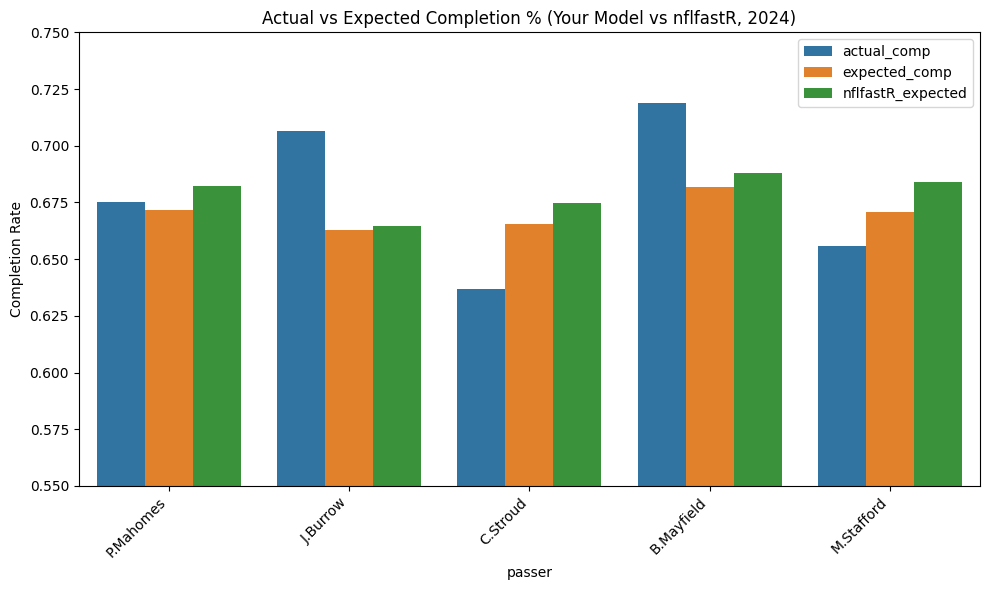

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pick top 10 QBs by attempts
top_qbs = qb_summary.sort_values("attempts", ascending=False).head(5).copy()

plt.figure(figsize=(10,6))
bar_df = top_qbs.melt(
    id_vars=["passer"],
    value_vars=["actual_comp", "expected_comp", "nflfastR_expected"],
    var_name="Metric",
    value_name="Completion Rate"
)

sns.barplot(data=bar_df, x="passer", y="Completion Rate", hue="Metric")
plt.xticks(rotation=45, ha="right")
plt.title("Actual vs Expected Completion % (Your Model vs nflfastR, 2024)")
plt.ylim(0.55, 0.75)
plt.legend(title="")
plt.tight_layout()
plt.show()

/tmp/ipython-input-2466336203.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  mat = (tmp.pivot_table(index="down", columns="ydstogo_bin",


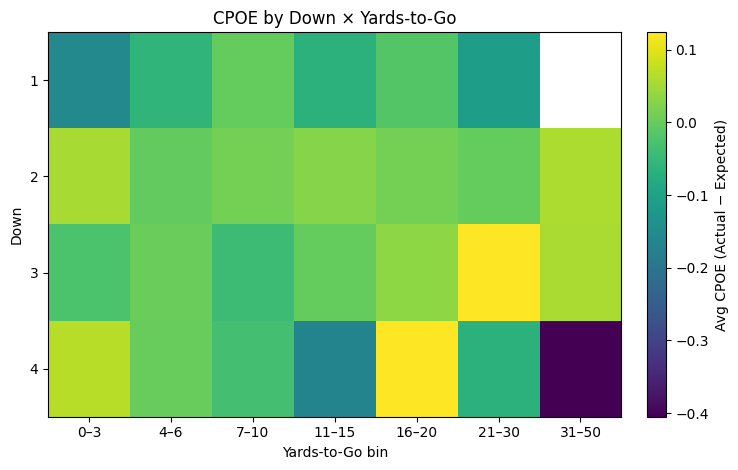

In [33]:
import pandas as pd
# make distance bins
bins_yds = [0,3,6,10,15,20,30,50,1e9]
labels_yds = ["0–3","4–6","7–10","11–15","16–20","21–30","31–50","50+"]

tmp = valid.copy()
tmp["ydstogo_bin"] = pd.cut(pd.to_numeric(tmp["ydstogo"], errors="coerce"),
                            bins=bins_yds, labels=labels_yds, right=True)
mat = (tmp.pivot_table(index="down", columns="ydstogo_bin",
                       values="your_cpoe", aggfunc="mean")
          .reindex(index=[1,2,3,4]))

plt.figure(figsize=(7.5,4.8))
im = plt.imshow(mat.values, aspect="auto", interpolation="nearest")
plt.xticks(range(len(mat.columns)), list(mat.columns))
plt.yticks(range(len(mat.index)), list(mat.index))
plt.colorbar(im, fraction=0.046, pad=0.04, label="Avg CPOE (Actual − Expected)")
plt.title("CPOE by Down × Yards-to-Go")
plt.xlabel("Yards-to-Go bin"); plt.ylabel("Down")
plt.tight_layout(); plt.show()

In [ ]:
# Power BI Data Export
import pandas as pd

cols_play = [
    "season","week","game_id","play_id","passer","defteam",
    "down","ydstogo","air_yards","yardline_100",
    "complete_pass","complete_model","your_cpoe",
    "roof","surface","temp","wind","score_differential"
]
play_export = valid[[c for c in cols_play if c in valid.columns]].copy()
play_export.to_csv("play_level_cpoe.csv", index=False)
print(f"Exported {len(play_export):,} play rows → play_level_cpoe.csv")

cols_qb = [
    "season","passer","attempts",
    "actual_comp","expected_comp",
    "your_cpoe","nflfastR_expected","nflfastR_cpoe",
    "difference_expected_vs_fastr","difference_cpoe_vs_fastr"
]

qb_export = qb_summary[[c for c in cols_qb if c in qb_summary.columns]].copy()

pct_cols = [
    "actual_comp","expected_comp","your_cpoe",
    "nflfastR_expected","nflfastR_cpoe",
    "difference_expected_vs_fastr","difference_cpoe_vs_fastr"
]
for c in [x for x in pct_cols if x in qb_export.columns]:
    qb_export[c] = (qb_export[c] * 100).round(2)

# Rename for clarity in Power BI
qb_export = qb_export.rename(columns={
    "actual_comp": "actual_comp_pct",
    "expected_comp": "expected_comp_pct",
    "your_cpoe": "model_cpoe_pp",
    "nflfastR_expected": "nflfastR_cp_pct",
    "nflfastR_cpoe": "nflfastR_cpoe_pp",
    "difference_expected_vs_fastr": "delta_cp_vs_fastr",
    "difference_cpoe_vs_fastr": "delta_cpoe_vs_fastr"
})

qb_export.to_csv("qb_summary_cpoe.csv", index=False)
print(f"Exported {len(qb_export):,} QB summaries → qb_summary_cpoe.csv")

from google.colab import files
files.download("play_level_cpoe.csv")
files.download("qb_summary_cpoe.csv")

Exported 13,429 play rows → play_level_cpoe.csv
Exported 37 QB summaries → qb_summary_cpoe.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>